# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

/Users/victorgruselius/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


0.17.15


<AxesSubplot:title={'center':'Nutria population'}>

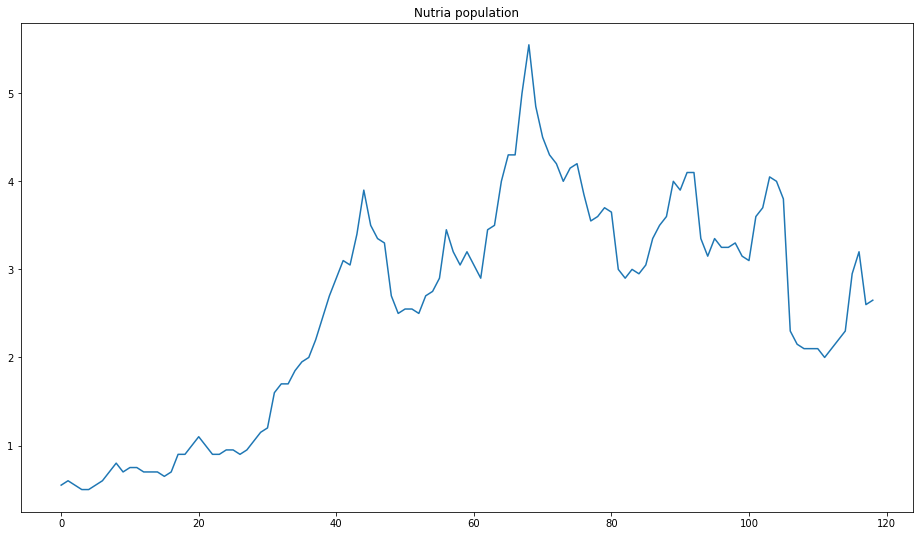

In [1]:
import pandas as pd
from pyfilter import __version__

print(__version__)

data = pd.read_csv('nutria.txt', sep='\t').iloc[:, 0].rename('nutria')

data.plot(figsize=(16, 9), title='Nutria population')

Next, we'll specify the model to use for inference. We'll use the flexible Allee model, found in .. . However, instead of considering the actual population, we'll use the logarithm.

In [2]:
from pyfilter.timeseries import LinearGaussianObservations, AffineProcess
from torch.distributions import Normal, Gamma, TransformedDistribution, AffineTransform, PowerTransform
import torch
from pyfilter.distributions import Prior, DistributionWrapper


def f(x, a, b, c, d):
    exped = x.values.exp()
    return x.values + a + b * exped + c * exped ** 2


def g(x, a, b, c, d):
    return d.sqrt()

def build_invgamma(concentration, rate, power, **kwargs):
    return TransformedDistribution(Gamma(alpha, rate, **kwargs), PowerTransform(power))


alpha = data.shape[0] / 2.0
beta = 2.0 * (alpha - 1.0) / 10.0

invgamma_prior = Prior(
    build_invgamma,
    concentration=alpha, 
    rate=beta,
    power=-1.0
) 

norm_prior = Prior(Normal, loc=0.0, scale=1.0)
h_priors = norm_prior, norm_prior, norm_prior, invgamma_prior

dist = DistributionWrapper(Normal, loc=0.0, scale=1.0)
hidden = AffineProcess((f, g), h_priors, dist, dist)

model = LinearGaussianObservations(hidden, 1.0, invgamma_prior)

Next, we'll use PMMH together with APF to perform inference on the logged dataset.

In [18]:
from pyfilter.inference.batch.mcmc import PMMH, proposal as p
from pyfilter.filters.particle import APF
import numpy as np


logged_data = torch.from_numpy(np.log(data).values).float()

filt = APF(model, 500)
alg = PMMH(filt, 2000, proposal_builder=p.GradientBasedProposal())

state = alg.fit(logged_data)

PMMH:   0%|          | 10/2000 [00:15<50:14,  1.51s/it]


KeyboardInterrupt: 

Next, let's visualize the filtered means of the state.

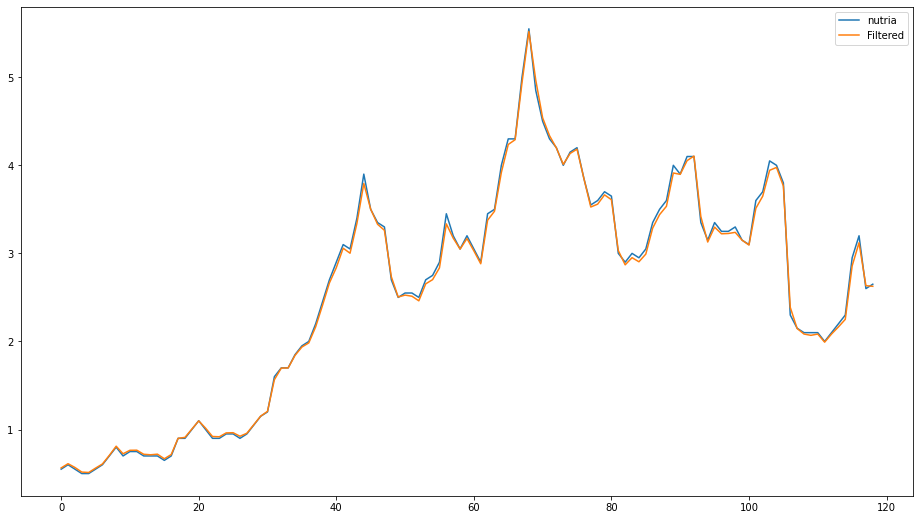

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

data.plot(ax=ax)

ax.plot(state.filter_result.filter_means.mean(dim=1)[1:].exp().cpu().numpy(), label='Filtered')

ax.legend()

Next, let's visualize the posterior distributions of the parameters.

tensor([[ 0.4336, -0.3595,  0.0747,  0.2288,  0.1656],
        [ 0.4333, -0.3646,  0.0463,  0.2252,  0.1664],
        [ 0.4336, -0.3595,  0.0747,  0.2288,  0.1656],
        ...,
        [ 0.4448, -0.3658,  0.0445,  0.2291,  0.1655],
        [ 0.4336, -0.3595,  0.0747,  0.2288,  0.1656],
        [ 0.4336, -0.3595,  0.0747,  0.2288,  0.1656]])


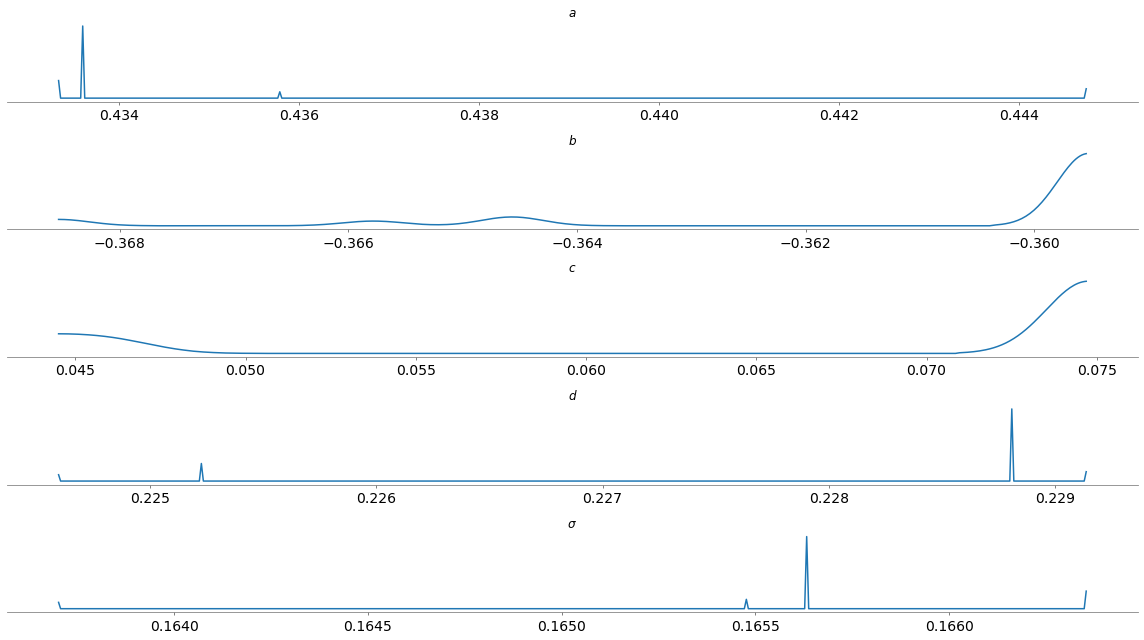

In [17]:
from pyfilter.utils import normalize
import pandas as pd
from arviz import plot_posterior

fig, ax = plt.subplots(5, figsize=(16, 9))
colors = ["lightblue", "orange"]

names = "a, b, c, d, \sigma".split(", ")

params = state.samples.values()[500:].reshape(-1, 5)

for i in range(params.shape[-1]):
     plot_posterior(params[:, i].numpy(), ax=ax[i], point_estimate=None, hdi_prob='hide')
     ax[i].set_title(f"${names[i]}$")

plt.tight_layout()